In [1]:
import pandas as pd

# 1. Load dataset
df = pd.read_csv("us-states.csv")

# 2. Tampilkan 5 baris awal
print("Data awal:")
print(df.head())

# 3. Cek info tipe data
print("\nInfo kolom:")
df.info()

# 4. Ubah kolom 'date' jadi format datetime
df['date'] = pd.to_datetime(df['date'])

# 5. Cek missing values
print("\nJumlah missing values per kolom:")
print(df.isnull().sum())

# 6. Tambahkan kolom kasus harian dan kematian harian per state
df = df.sort_values(['state', 'date'])  # Penting: urutkan dahulu

df['daily_cases'] = df.groupby('state')['cases'].diff().fillna(0).astype(int)
df['daily_deaths'] = df.groupby('state')['deaths'].diff().fillna(0).astype(int)

# 7. Tambahkan case fatality rate
df['fatality_rate'] = df['deaths'] / df['cases']
df['fatality_rate'] = df['fatality_rate'].fillna(0).round(4)

# 8. Hapus data negatif akibat anomali (jika ada)
df = df[(df['daily_cases'] >= 0) & (df['daily_deaths'] >= 0)]

# 9. Simpan hasil preprocess ke file baru
df.to_csv("us_states_preprocessed.csv", index=False)

print("\nPreprocessing selesai. File disimpan sebagai 'us_states_preprocessed.csv'")

Data awal:
         date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0

Info kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61942 entries, 0 to 61941
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    61942 non-null  object
 1   state   61942 non-null  object
 2   fips    61942 non-null  int64 
 3   cases   61942 non-null  int64 
 4   deaths  61942 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.4+ MB

Jumlah missing values per kolom:
date      0
state     0
fips      0
cases     0
deaths    0
dtype: int64

Preprocessing selesai. File disimpan sebagai 'us_states_preprocessed.csv'


In [99]:
import atoti as tt
import pandas as pd
from atoti import Session
import time

df = pd.read_csv("us_states_preprocessed.csv")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.strftime('%Y')
df["month"] = df["date"].dt.strftime('%B')

session = tt.Session.start()

covid_table = session.read_pandas(
    df,
    keys=["state", "date"],
    table_name="covid"
)

cube = session.create_cube(covid_table)
h= cube.hierarchies
h["Time"] = [covid_table["year"],covid_table["month"],covid_table["date"]]
h["Location"] = [covid_table["state"]]

# Measures seperti biasa
m = cube.measures
m["sum_daily_cases"] = tt.agg.sum(covid_table["daily_cases"])
m["sum_daily_deaths"] = tt.agg.sum(covid_table["daily_deaths"])
m["sum_cases"] = tt.agg.sum(covid_table["cases"])
m["sum_deaths"] = tt.agg.sum(covid_table["deaths"])
m["case_fatality_rate (%)"] = (m["sum_deaths"] / m["sum_cases"]) * 100


print(session.link)
# Biar session tetap hidup dan server jalan terus
print("Press Ctrl+C to stop the server")
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Server stopped")



http://localhost:62429
Press Ctrl+C to stop the server
Server stopped


In [100]:
covid_table.columns


C:\Users\zulai\AppData\Local\Temp\ipykernel_14992\1032444978.py:1: FutureWarning: `Table.columns` is deprecated, use `list(table)` instead.
  covid_table.columns


['date',
 'state',
 'fips',
 'cases',
 'deaths',
 'daily_cases',
 'daily_deaths',
 'fatality_rate',
 'year',
 'month']

In [101]:
 cube.hierarchies

{('covid', 'date'): <atoti.hierarchy.Hierarchy object at 0x0000026D807AA9F0>, ('covid', 'state'): <atoti.hierarchy.Hierarchy object at 0x0000026D807AA7B0>, ('covid', 'month'): <atoti.hierarchy.Hierarchy object at 0x0000026D807A8EF0>, ('covid', 'year'): <atoti.hierarchy.Hierarchy object at 0x0000026D807AAB10>, ('covid', 'Time'): <atoti.hierarchy.Hierarchy object at 0x0000026D807AAF60>, ('covid', 'Location'): <atoti.hierarchy.Hierarchy object at 0x0000026D807AABA0>}

In [102]:
m = cube.measures
m

{'fatality_rate.SUM': <atoti.measure.Measure object at 0x0000026D81F8A000>, 'deaths.MEAN': <atoti.measure.Measure object at 0x0000026D81F89A60>, 'daily_cases.SUM': <atoti.measure.Measure object at 0x0000026D81F88080>, 'daily_deaths.SUM': <atoti.measure.Measure object at 0x0000026D81F88F50>, 'cases.SUM': <atoti.measure.Measure object at 0x0000026D81F88740>, 'fatality_rate.MEAN': <atoti.measure.Measure object at 0x0000026D81F88140>, 'deaths.SUM': <atoti.measure.Measure object at 0x0000026D81F88860>, 'contributors.COUNT': <atoti.measure.Measure object at 0x0000026D81F885F0>, 'fips.MEAN': <atoti.measure.Measure object at 0x0000026D81F89B20>, 'daily_cases.MEAN': <atoti.measure.Measure object at 0x0000026D81F887A0>, 'daily_deaths.MEAN': <atoti.measure.Measure object at 0x0000026D81F881A0>, 'cases.MEAN': <atoti.measure.Measure object at 0x0000026D81F880E0>, 'fips.SUM': <atoti.measure.Measure object at 0x0000026D81F88800>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x0000026D81F886E0>, 'sum_daily_cases': <atoti.measure.Measure object at 0x0000026D81F89D90>, 'sum_daily_deaths': <atoti.measure.Measure object at 0x0000026D81F880B0>, 'sum_cases': <atoti.measure.Measure object at 0x0000026D81F88260>, 'sum_deaths': <atoti.measure.Measure object at 0x0000026D81F885C0>, 'case_fatality_rate (%)': <atoti.measure.Measure object at 0x0000026D81F884D0>}

In [55]:
session.tables
session.tables.schema

```mermaid
erDiagram
  "covid" {
    non-null LocalDate "date"
    non-null String PK "state"
    nullable long "fips"
    nullable long "cases"
    nullable long "deaths"
    nullable long "daily_cases"
    nullable long "daily_deaths"
    nullable double "fatality_rate"
    non-null String "year"
    non-null String "month"
  }
```


In [103]:
l = cube.levels
l

{('covid', 'date', 'date'): <atoti.level.Level object at 0x0000026D807AA060>, ('covid', 'state', 'state'): <atoti.level.Level object at 0x0000026D807A8DA0>, ('covid', 'month', 'month'): <atoti.level.Level object at 0x0000026D807A9CA0>, ('covid', 'year', 'year'): <atoti.level.Level object at 0x0000026D807AB290>, ('covid', 'Time', 'year'): <atoti.level.Level object at 0x0000026D807AB440>, ('covid', 'Time', 'month'): <atoti.level.Level object at 0x0000026D807A8890>, ('covid', 'Time', 'date'): <atoti.level.Level object at 0x0000026D807AB8C0>, ('covid', 'Location', 'state'): <atoti.level.Level object at 0x0000026D807A83E0>}

In [105]:
print(cube.levels.keys())


dict_keys([('covid', 'date', 'date'), ('covid', 'state', 'state'), ('covid', 'month', 'month'), ('covid', 'year', 'year'), ('covid', 'Location', 'state'), ('covid', 'Time', 'Year'), ('covid', 'Time', 'Month'), ('covid', 'Time', 'Date')])


In [138]:
print(df["year"] .unique())
print(df["month"].unique())


['2020' '2021' '2022' '2023']
['March' 'April' 'May' 'June' 'July' 'August' 'September' 'October'
 'November' 'December' 'January' 'February']


In [142]:
# 1. Total kasus nasional
print("Total kasus nasional:")
query1 = cube.query(m["sum_cases"])
result1 = query1.sort_values(by="sum_cases", ascending=False)
result1


Total kasus nasional:


,sum_cases
0,54737145614


In [148]:
# 2 negara bagian dengan kematian terbanyak
print ("Negara bagian dengan kematian terbanyak")
query2 = cube.query(m["sum_deaths"], levels=[cube.levels["covid", "Location", "state"]])
result2 = query2.sort_values("sum_deaths", ascending=False).head(1)
result2

Negara bagian dengan kematian terbanyak


,sum_deaths
state,
California,66691205


In [178]:
# 3. Negara bagian dengan kematian perhari tertinggi di Januari 2021
print("\nNegara bagian dengan kematian perhari tertinggi di Januari 2021:")

query3 = cube.query(
    m["sum_daily_deaths"],
    levels=[cube.levels["covid", "Location", "state"],
           cube.levels["covid", "Time", "Year"],
           cube.levels["covid", "Time", "Month"]],
    filter=(
        (cube.levels["covid", "Time", "Year"] == "2021") &
        (cube.levels["covid", "Time", "Month"] == "January")
    ),
    mode = "raw"
)

result3 = query3.sort_values(by="sum_daily_deaths", ascending=False).head(5)
result3



Negara bagian dengan kematian perhari tertinggi di Januari 2021:


,state,Year,Month,sum_daily_deaths
4,California,2021,January,14963
46,Texas,2021,January,9087
40,Pennsylvania,2021,January,5695
33,New York,2021,January,5621
9,Florida,2021,January,4806


In [149]:
# 4. Negara bagian dengan fatality rate tertinggi
print("\nNegara bagian dengan fatality rate tertinggi:")
query4 = cube.query(m["case_fatality_rate (%)"],levels=[cube.levels["covid", "Location", "state"]])  
result4 = query4.sort_values(by = "case_fatality_rate (%)", ascending = False)
result4



Negara bagian dengan fatality rate tertinggi:


,case_fatality_rate (%)
state,
New Jersey,1.801293
Connecticut,1.748534
Pennsylvania,1.732626
New York,1.699094
Mississippi,1.669587
Michigan,1.629312
Massachusetts,1.581531
Louisiana,1.561127
Arizona,1.553072


In [174]:
# 5. Negara bagian dengan kasus tertinggi
print("\nNegara bagian dengan kasus tertinggi:")
query5 = cube.query(m["sum_cases"], levels=[cube.levels["covid", "Location", "state"]],
                   mode="raw")
result5 = query5.sort_values("sum_cases", ascending=False).head(5)
result5



Negara bagian dengan kasus tertinggi:


,state,sum_cases
5,California,6251672544
47,Texas,4628783760
10,Florida,4049788557
34,New York,3437931225
15,Illinois,2182620663


In [173]:
print("\nNegara bagian dengan kematian perhari tertinggi:")

query6 = cube.query(
    m["sum_daily_deaths"],
    levels=[cube.levels["covid", "Location", "state"]],
    mode="raw"
)

result6 = query6.sort_values(by="sum_daily_deaths", ascending=False).head(5)
result6


Negara bagian dengan kematian perhari tertinggi:


,state,sum_daily_deaths
5,California,105198
47,Texas,94604
10,Florida,87142
34,New York,80415
41,Pennsylvania,50562


In [154]:
print("\nJumlah kematian di negara bagian Florida selama tahun 2022:")

query6 = cube.query(
    m["sum_deaths"],
    levels=[
        cube.levels["covid", "Location", "state"],
        cube.levels["covid", "Time", "Year"]
    ],
    filter=(
        (cube.levels["covid", "Location", "state"] == "Florida") &
        (cube.levels["covid", "Time", "Year"] == "2022")
    ),
    mode="raw"
)

result6 = query6.sort_values("sum_deaths", ascending=False)
result6



Jumlah kematian di negara bagian Florida selama tahun 2022:


,state,Year,sum_deaths
0,Florida,2022,27554224


In [155]:
print("\nJumlah kasus harian di Texas pada Februari 2020:")

query7 = cube.query(
    m["sum_daily_cases"],
    levels=[
        cube.levels["covid", "Location", "state"],
        cube.levels["covid", "Time", "Year"],
        cube.levels["covid", "Time", "Month"],
    ],
    filter=(
        (cube.levels["covid", "Location", "state"] == "Texas") &
        (cube.levels["covid", "Time", "Year"] == "2020") &
        (cube.levels["covid", "Time", "Month"] == "February")
    ),
    mode="raw"
)
result7 = query7.sort_values("sum_daily_cases", ascending=False)
result7



Jumlah kasus harian di Texas pada Februari 2020:


,state,Year,Month,sum_daily_cases
0,Texas,2020,February,10


In [175]:
print("\nNegara bagian dengan kematian tertinggi:")

query8 = cube.query(
    m["sum_deaths"],
    levels=[cube.levels["covid", "Location", "state"]],
    mode="raw"
)

result8 = query8.sort_values(by="sum_deaths", ascending=False).head(5)
result8


Negara bagian dengan kematian tertinggi:


,state,sum_deaths
5,California,66691205
47,Texas,62706557
34,New York,58413679
10,Florida,52503664
41,Pennsylvania,32506859


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
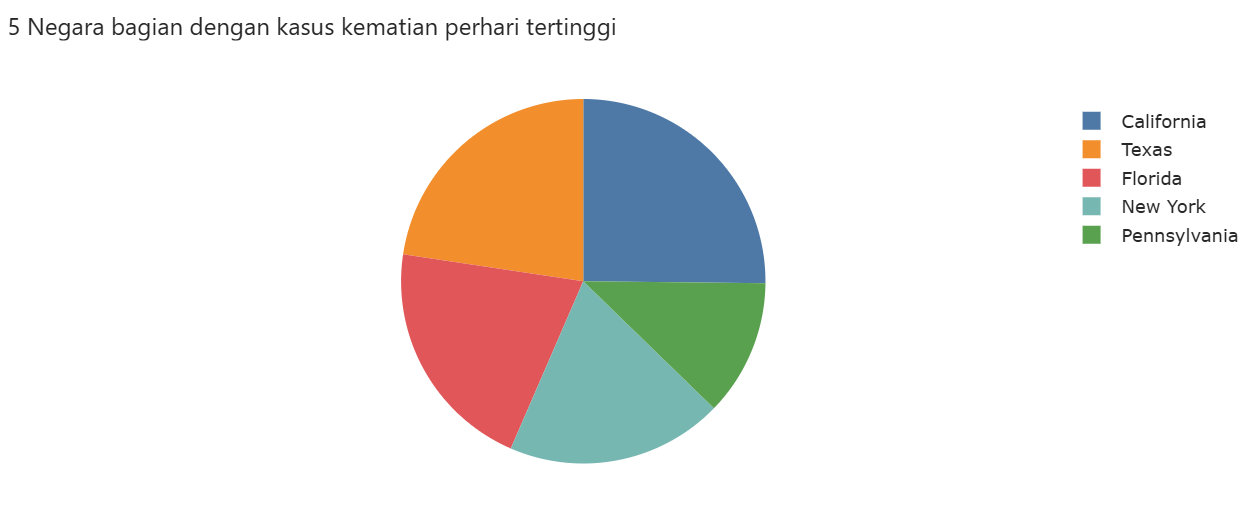

In [156]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
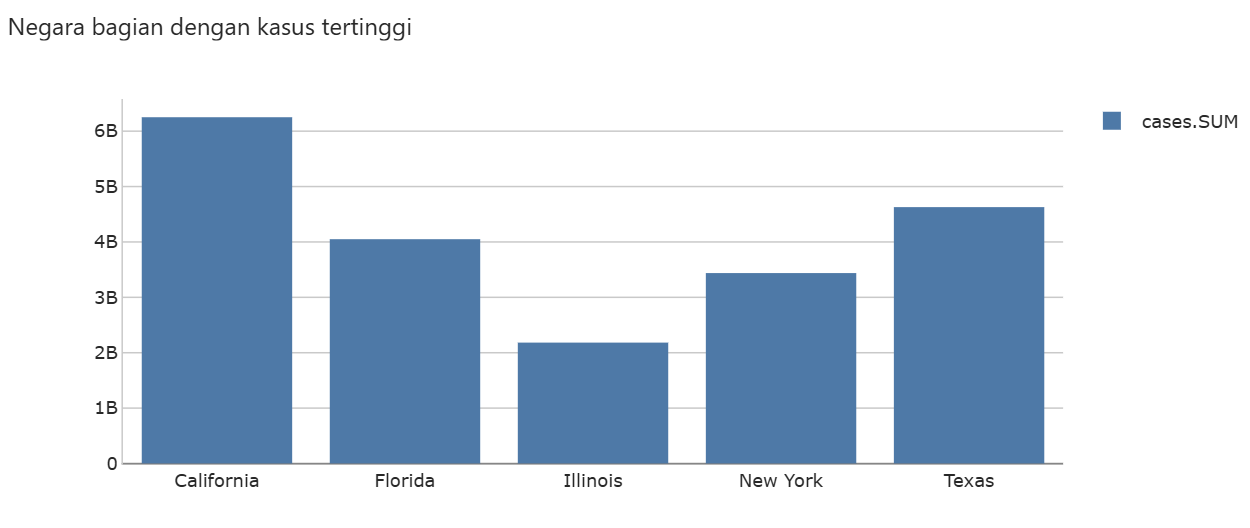

In [157]:
session.widget

In [176]:
print(result5.columns)
print(result8.columns)



Index(['state', 'sum_cases'], dtype='object')
Index(['state', 'sum_deaths'], dtype='object')


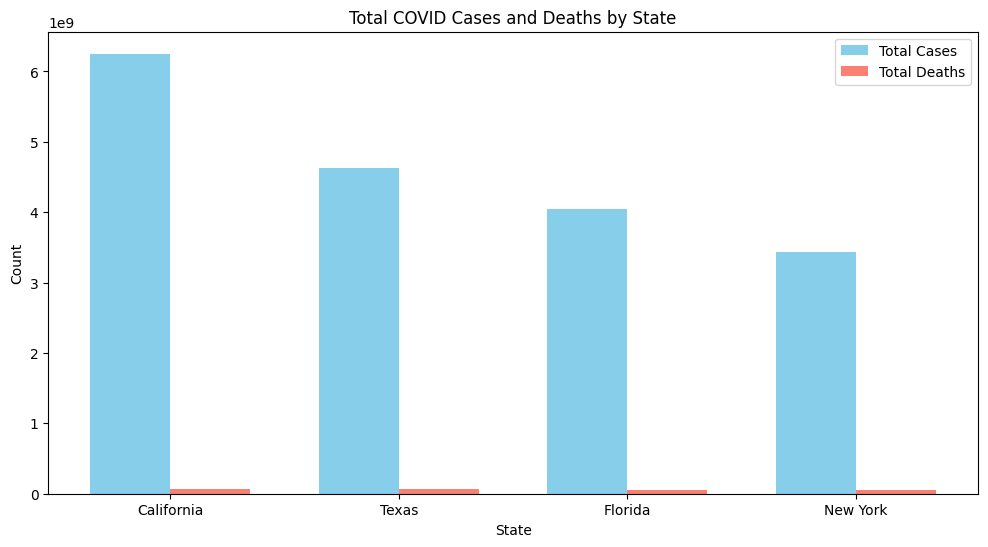

In [177]:
# Visualisasi join deaths and cases
import matplotlib.pyplot as plt
import numpy as np

merged = pd.merge(result5, result8, on='state')


states = merged['state']
cases = merged['sum_cases']
deaths = merged['sum_deaths']

x = np.arange(len(states))
width = 0.35 

fig, ax = plt.subplots(figsize=(12,6))

bar1 = ax.bar(x - width/2, cases, width, label='Total Cases', color='skyblue')
bar2 = ax.bar(x + width/2, deaths, width, label='Total Deaths', color='salmon')

# Label dan judul
ax.set_xlabel('State')
ax.set_ylabel('Count')
ax.set_title('Total COVID Cases and Deaths by State')
ax.set_xticks(x)
ax.set_xticklabels(states)
ax.legend()

plt.show()
